# HarvestStat Data Profiling - Senegal

In [1]:
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import geopandas as gpd
from tools import retreive_fdw_data, save_npz, PrintAdminUnits, PlotAdminShapes
from tools import FDW_PD_Sweeper, FDW_PD_AvalTable, FDW_PD_Compiling, FDW_PD_ValidateFnidName
from tools import FDW_PD_CreateAdminLink, FDW_PD_RatioAdminLink, FDW_PD_ConnectAdminLink
from tools import product_name_mapping, FDW_PD_CaliSeasonYear, FDW_PD_MergeCropProductionSystem
from tools_graphic import PlotBarProduction, PlotLinePAY
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

In [2]:
# Set loading parameters ------------------------ #
country_name = 'Senegal'
country_iso2 = 'SN'
use_api_data = False
requires_authentication = False
# ----------------------------------------------- #

# Load FEWS NET administrative boundaries ------- #
epsg = 'epsg:32628' # Senegal
fn_shapes = sorted(glob.glob(f"../data/shapefile/fewsnet/{country_iso2}_Admin?_????.shp"))
shape_all = []
for fn in fn_shapes:
    name = fn[-18:-4]
    exec('%s = gpd.read_file("%s").to_crs("%s")' % (name, fn, epsg))
    exec('%s["area"] = %s["geometry"].area/10**6' % (name, name))
    exec('shape_all.append(%s)' % (name))
shape_all = pd.concat(shape_all, axis=0).reset_index(drop=True)
# PrintAdminUnits(shape_all)
# ----------------------------------------------- #

# Load FDW data -------------------------------- #
df = retreive_fdw_data(country_name, country_iso2, use_api_data, requires_authentication)
# ----------------------------------------------- #

Data is loaded from the local file.
../data/crop_raw_data/adm_crop_data_raw_SN.csv is loaded.


In [3]:
# Manual Pre-processing before Sweeping --------- #
# 1. Default setting 
# a) None-type crop production system
df.loc[df['crop_production_system'].isna(), 'crop_production_system'] = 'none'
df.loc[df['crop_production_system'] == '', 'crop_production_system'] = 'none'
# b) None-type population group
df.loc[df['population_group'].isna(), 'population_group'] = 'none'
df.loc[df['population_group'] == '', 'population_group'] = 'none'
# 2. Manual setting
# a) Add admin names to reporting units
admin_level = 'admin_2'
reporting_unit = df.loc[df['fnid'].map(lambda x: x[6] != 'A'), 'fnid'].unique()
df.loc[df.fnid.isin(reporting_unit),admin_level] = df.loc[df.fnid.isin(reporting_unit), 'locality_name'].map(lambda x: x.split(' ')[0])
# Change the season names
season_name_dict = {
    'Main season': 'Main',
    'Off season': 'Main-off',
}
df['season_name'] = df['season_name'].map(season_name_dict)
# ----------------------------------------------- #

# FDW Production Data Inspection ---------------- #
df, df_raw = FDW_PD_Sweeper(df, area_priority='Area Planted')
table_dict = FDW_PD_AvalTable(df, shape_all)
# ----------------------------------------------- #

# FEWS NET Shapefile comparison ----------------- #
shape_used = pd.concat([
    SN_Admin2_1960, SN_Admin2_1980, SN_Admin2_1984,
    SN_Admin2_2002, SN_Admin2_2006, SN_Admin2_2008
], axis=0)
PlotAdminShapes(shape_used, label=True)
# ----------------------------------------------- #

- Remove missing records ---------------------- #
Orignial data points: 21,651
Removed 130 "Missing Value" points
7,207/7,217 "Area Planted" points are retained.
7,162/7,217 "Quantity Produced" points are retained.
7,152/7,217 "Yield" points are retained.
Current data points: 21,521



- Minor changes are applied ------------------- #

- Basic information --------------------------- #
Data period: 1960 - 2015
10 grain types are found: Cassava, Cowpeas (Mixed), Fonio, Groundnuts (In Shell), Maize (Corn), Millet (Bulrush), Rice (Paddy), Sesame Seed, Sorghum, Sweet Potatoes
2 seasons are found: Main (12-01), Main-off (02-01)
3 crop production system are found: none, irrigated, recessional (PS)
Data sources include:
[1] Agence Nationale de la Statistique et de la Demographie, Senegal --- Situation Socio-Economique, Senegal
[2] Agence Nationale de la Statistique, Senegal --- Situation Socio-Economique, Senegal
[3] Ministere de l'agriculture et du developpement rural, DAPSA, Senegal --- FEWS NET Agro Maps, Senegal
[4] Ministere de l'agriculture et du developpement rural, DAPSA, Senegal --- Situation Socio-Economique, Senegal


Administrative-1 fnids: 0
Administrative-2 fnids: 160
0 reporting units are found: 

- Total production over time ------------------ #
season_name             Main Main-off
                                     
Cassava                 1.8%     0.0%
Cowpeas (Mixed)         1.7%     0.0%
Fonio                   0.0%     0.0%
Groundnuts (In Shell)  45.0%     0.0%
Maize (Corn)            5.4%     0.0%
Millet (Bulrush)       30.6%     0.0%
Rice (Paddy)           10.6%     0.4%
Sesame Seed             0.1%     0.0%
Sorghum                 4.4%     0.0%
Sweet Potatoes          0.0%     0.0%

- Crop calendar ------------------------------- #
                  product season_name planting_month harvest_month
0                 Cassava        Main          12-01         12-01
1         Cowpeas (Mixed)        Main          12-01         12-01
2                   Fonio        Main          12-01         12-01
3   Groundnuts (In Shell)        Main          12-01         12-01
4   Groundnuts (In Shel

- Recorded years per season ------------------- #
Main: 56 years (1960-2015) (missing: 0 years)
Main-off: 12 years (2000-2011) (missing: 4 years)

- Number of "Quantity Produced" data points --- #
SN1960A2: 1,991 data points are found.
SN1980A2: 299 data points are found.
SN1984A2: 2,062 data points are found.
SN2002A2: 1,041 data points are found.
SN2008A2: 1,769 data points are found.

- Districts with population group(s) ---------- #
0 districts includes 'population_group'.

Table of available data


----------------------------------------------- #
Crop type: Cassava
----------------------------------------------- #
season_name              Main              
crop_production_system   none              
fnid_short             1984A2 2002A2 2008A2
year                                       
1996                     6/30    NaN    NaN
1997                      NaN    NaN    NaN
1998                      NaN    NaN    NaN
1999                      NaN    NaN    NaN
2000                      NaN    NaN    NaN
2001                      NaN    NaN    NaN
2002                      NaN   2/34    NaN
2003                      NaN   4/34    NaN
2004                      NaN   7/34    NaN
2005                      NaN  12/34    NaN
2006                      NaN  16/34    NaN
2007                      NaN  10/34    NaN
2008                      NaN  13/34    NaN
2009                      NaN    NaN   5/45
2010                      NaN    NaN  27/45
2011                      NaN    NaN  28/45
2

../figures/SN_admin_shapes.png is saved.


- Senegal crop seasonal calendar

<img src="../figures/crop_calendar/seasonal-calendar-senegal.png"  width=900>

- FDW data consists of `SN1960A2`, `SN1980A2`, `SN1984A2`, `SN2002A2`, `SN2006A2`, and `SN2008A2`.

| Year | Admin-1 | # units  | Admin-2  | # units |
| :---: | :----:  | :----:   | :----:   | :---:  |
| 1960	 | SN1960A1 | 7	| **`SN1960A2`**	| 28	|
| 1980	 | SN1980A1 | 8	| **`SN1980A2`**	| 28	|
| 1984	 | SN1984A1 | 10	| **`SN1984A2`**	| 30	|
| 2002	 | SN2002A1 | 11	| **`SN2002A2`**	| 34	|
| 2006	 | - | -	| **`SN2006A2`**	| 35	|
| 2008	 | SN2008A1 | 14	| **`SN2008A2`**	| 45	|

- Comparison between admin boundaries.

<img src="../figures/SN_admin_shapes.png"  width=900>

- In 1980, no district is divided and added.

- In 1984, 2 districts are divided and added.</br>

| 1980-1984 | 1984-2002|
| :---:|:---:|
|SN1980A20101 (Dakar) | SN1984A20102 (Pikine), SN1984A20103 (Rufisque), SN1984A20104 (Dakar)|

- In 2002, 4 districts are divided and added.</br>

| 1984-2002 | 2002-2006|
| :---:|:---:|
|SN1984A20102 (Pikine) | SN2002A20105 (Pikine), SN2002A20106 (Guediawaye)|
|SN1984A20401 (Dagana) | SN2002A21701 (Dagana), SN2002A21703 (Saint-Louis)|
|SN1984A20402 (Matam) | SN2002A21801 (Kanel), SN2002A21802 (Matam), SN2002A21803 (Ranerou Ferlo)|

- In 2006, 1 district is divided and added.</br>

| 2002-2006 | 2006-2008 |
| :---:|:---:|
|SN2002A21601 (Kaffrine) | SN2006A21601 (Kaffrine), SN2006A21604 (Koungheul)|

- In 2008, 10 district are divided and added.</br>

| 2006-2008 | 2008-present |
| :---:|:---:|
|SN2006A21503 (Gossas) | SN2008A22401 (Guinguineo), SN2008A22603 (Gossas)|
|SN2006A20502 (Kedougou) | SN2008A22301 (Kedougou), SN2008A22302 (Salemata), SN2008A22303 (Kolda)|
|SN2006A21101 (Kolda) | SN2008A22001 (Kolda), SN2008A22003 (Medina Yoro Foulah)|
|SN2006A21102 (Sedhiou) | SN2008A22101 (Bounkiling), SN2008A22102 (Goudomp), SN2008A22103 (Sedhiou)|
|SN2006A20501 (Bakel) | SN2008A22201 (Bakel), SN2008A22202 (Goudiry)|
|SN2006A20503 (Tambacounda) | SN2008A22203 (Koumpentoum), SN2008A22204 (Tambacounda)|
|SN2006A21601 (Kaffrine) | SN2008A22501 (Birkelane), SN2008A22502 (Kaffrine), SN2008A22504 (Malem Hoddar)|

- **`SN2008A2`** is used to represent current admin-level 2 crop data.
- Senegal has 2 crop seasons: Main season (12-01), Off season (02-01).
- Senegal has 3 crop production systems: None, irrigated, recessional (PS).
- Senegal has no population group(s).

In [4]:
# Define the latest shapefile ------------------- #
latest_level = 2
shape_latest = SN_Admin2_2008.copy().to_crs('epsg:4326')
# ----------------------------------------------- #

# Validation of FNIDs and Names ----------------- #
df = FDW_PD_ValidateFnidName(df, shape_used, shape_latest)
# ----------------------------------------------- #

# FDW Production Data Compiling ----------------- #
area, prod = FDW_PD_Compiling(df, shape_used)
area_all, prod_all = area.copy(), prod.copy()
mdx_pss = area.columns.droplevel([0,1]).unique()
# ----------------------------------------------- #

In [5]:
# Link admin boundaries ------------------------- #
link_1960, over_1960 = FDW_PD_CreateAdminLink(SN_Admin2_1960, SN_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)
link_1960['SN1960A20101'].update(method='PBR')
link_1960['SN1960A20304'].update(method='PBR')
link_1960['SN1960A20402'].update(method='PBR')
assert all(np.unique([v['method'] for k,v in link_1960.items()]) == 'PBR')
link_1980, over_1980 = FDW_PD_CreateAdminLink(SN_Admin2_1980, SN_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)
link_1980['SN1980A20101'].update(method='PBR')
link_1980['SN1980A20902'].update(method='PBR')
link_1980['SN1980A20402'].update(method='PBR')
assert all(np.unique([v['method'] for k,v in link_1980.items()]) == 'PBR')
link_1984, over_1984 = FDW_PD_CreateAdminLink(SN_Admin2_1984, SN_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)
link_1984['SN1984A20104'].update(method='PBR')
link_1984['SN1984A20102'].update(method='PBR')
link_1984['SN1984A20902'].update(method='PBR')
link_1984['SN1984A20402'].update(method='PBR')
assert all(np.unique([v['method'] for k,v in link_1984.items()]) == 'PBR')
link_2002, over_2002 = FDW_PD_CreateAdminLink(SN_Admin2_2002, SN_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2002['SN2002A20104'].update(method='PBR')
link_2002['SN2002A20106'].update(method='PBR')
link_2002['SN2002A20105'].update(method='PBR')
assert all(np.unique([v['method'] for k,v in link_2002.items()]) == 'PBR')
link_2006, over_2006 = FDW_PD_CreateAdminLink(SN_Admin2_2006, SN_Admin2_2008, 'ADMIN2', 'ADMIN2', prod, epsg)
link_2006['SN2006A20104'].update(method='PBR')
link_2006['SN2006A20106'].update(method='PBR')
link_2006['SN2006A20105'].update(method='PBR')
assert all(np.unique([v['method'] for k,v in link_2006.items()]) == 'PBR')
# Crop specific ratios
link_ratio_1960 = FDW_PD_RatioAdminLink(link_1960, prod, over_1960, mdx_pss)
link_ratio_1980 = FDW_PD_RatioAdminLink(link_1980, prod, over_1980, mdx_pss)
link_ratio_1984 = FDW_PD_RatioAdminLink(link_1984, prod, over_1984, mdx_pss)
link_ratio_2002 = FDW_PD_RatioAdminLink(link_2002, prod, over_2002, mdx_pss)
link_ratio_2006 = FDW_PD_RatioAdminLink(link_2006, prod, over_2006, mdx_pss)
# Merge link_ratio
assert link_ratio_1960.keys() == link_ratio_1980.keys()
assert link_ratio_1980.keys() == link_ratio_1984.keys()
assert link_ratio_1984.keys() == link_ratio_2002.keys()
assert link_ratio_2002.keys() == link_ratio_2006.keys()
link_merged = [link_ratio_1960, link_ratio_1980, link_ratio_1984, link_ratio_2002, link_ratio_2006]
fnids_new = list(link_merged[0].keys())
link_ratio = dict()
for fnid in fnids_new:
    container = []
    for link in link_merged:
        container.append(link[fnid])
    link_ratio[fnid] = pd.concat(container, axis=1)
# Add current unit to link_ratio
for fnid_new in link_ratio.keys():
    link_ratio[fnid_new][fnid_new] = 1.0
    link_ratio[fnid_new] = link_ratio[fnid_new].sort_index(axis=1, ascending=False)
# Connect data with AdminLink
area_new, prod_new = FDW_PD_ConnectAdminLink(link_ratio, area, prod, validation=True)
# ----------------------------------------------- #

CBR is considered for 'SN1960A20101' as no record found in: ['SN2008A20105', 'SN2008A20106']


CBR is considered for 'SN1980A20101' as no record found in: ['SN2008A20105', 'SN2008A20106']


CBR is considered for 'SN1984A20102' as no record found in: ['SN2008A20105', 'SN2008A20106']


CBR is considered for 'SN2002A20106' as no record found in: ['SN2008A20106']
CBR is considered for 'SN2002A20105' as no record found in: ['SN2008A20105']


CBR is considered for 'SN2006A20106' as no record found in: ['SN2008A20106']
CBR is considered for 'SN2006A20105' as no record found in: ['SN2008A20105']


In [6]:
# Manual correction ----------------------------- #
crop_new = prod_new/area_new
# ----------------------------------------------- #

# Complete long format DataFrame ---------------- #
df_area = area_new.T.stack().rename('value').reset_index()
df_area['indicator'] = 'area'
df_prod = prod_new.T.stack().rename('value').reset_index()
df_prod['indicator'] = 'production'
df_yield = (prod_new/area_new).T.stack().rename('value').reset_index()
df_yield['indicator'] = 'yield'
stack = pd.concat([df_area, df_prod, df_yield], axis=0)
# Add "planting year"
cols = ['season_name','product','crop_production_system','planting_month','harvest_year','harvest_month','planting_year']
season_table = df[cols].drop_duplicates()
stack = stack.merge(season_table, on=cols[:-1])
# Add country and admin names
stack = stack.merge(df[['fnid','country','country_code','admin_1','admin_2']].drop_duplicates(), on='fnid', how='inner')
names = [
    'fnid','country','country_code','admin_1','admin_2','name',
    'product','season_name','planting_year','planting_month','harvest_year','harvest_month',
    'crop_production_system','indicator','value'
]
stack = stack[names]
# ----------------------------------------------- #

# Final Processing ------------------------------ #
# Product name mapping
stack = product_name_mapping(stack, list_except=None)
# Calibration of crop calendar using External Season Calendar (ESC)
esc = pd.read_csv('../data/crop_calendar/external_season_calendar.csv')
stack, link_ratio = FDW_PD_CaliSeasonYear(stack, esc, link_ratio=None)
# None admin names
stack.loc[stack['admin_1'].isna(), 'admin_1'] = 'none'
stack.loc[stack['admin_2'].isna(), 'admin_2'] = 'none'
# ----------------------------------------------- #

#define a QC flag field
# 0 = no flag
# 1 = outlier
stack['QC_flag'] = 0

All [country, season_name] are in the external season calendar.


## Postprocessing outlier removal

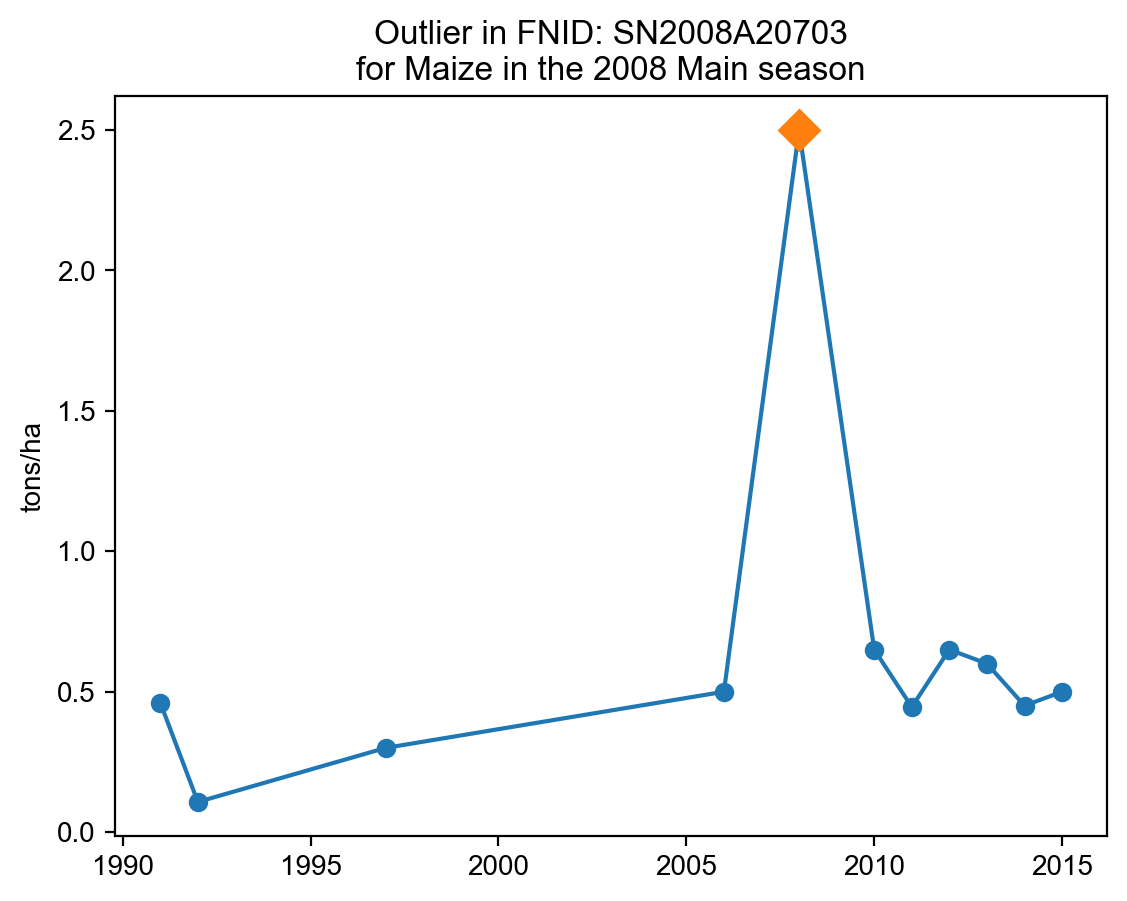

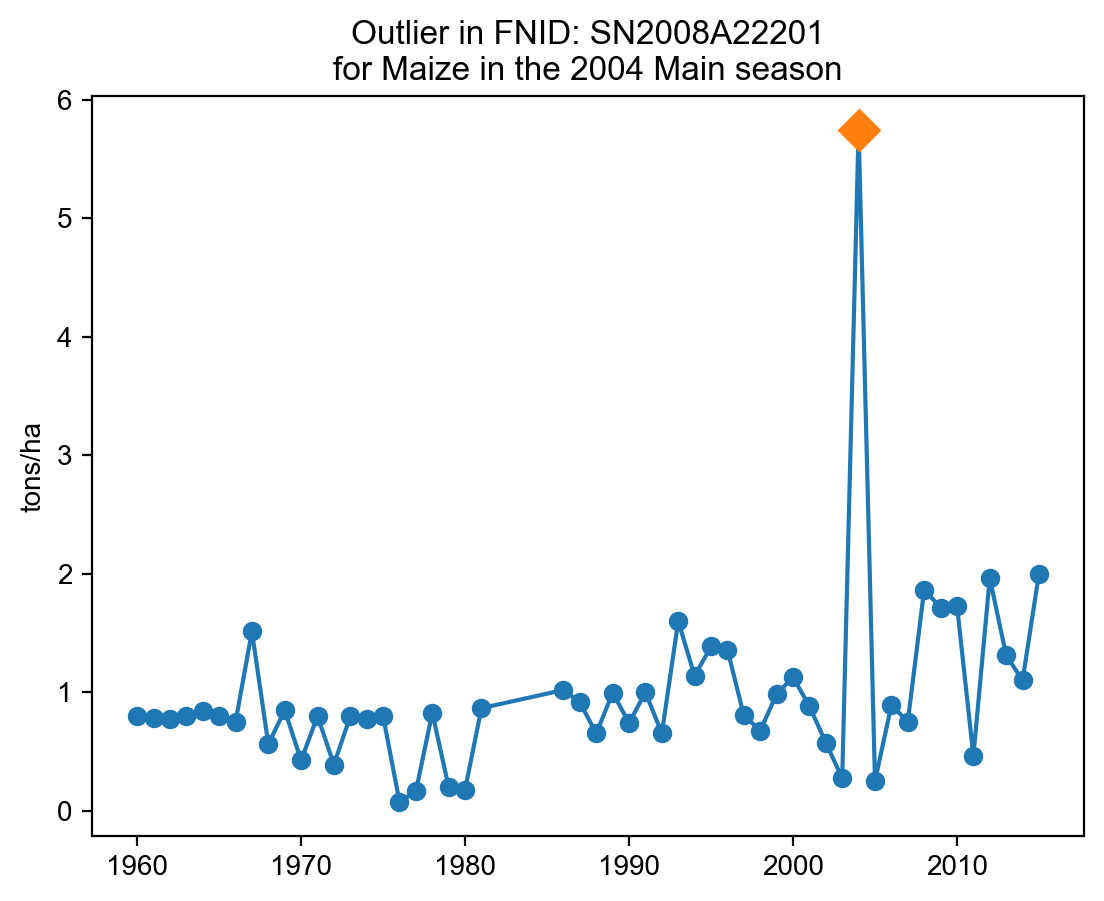

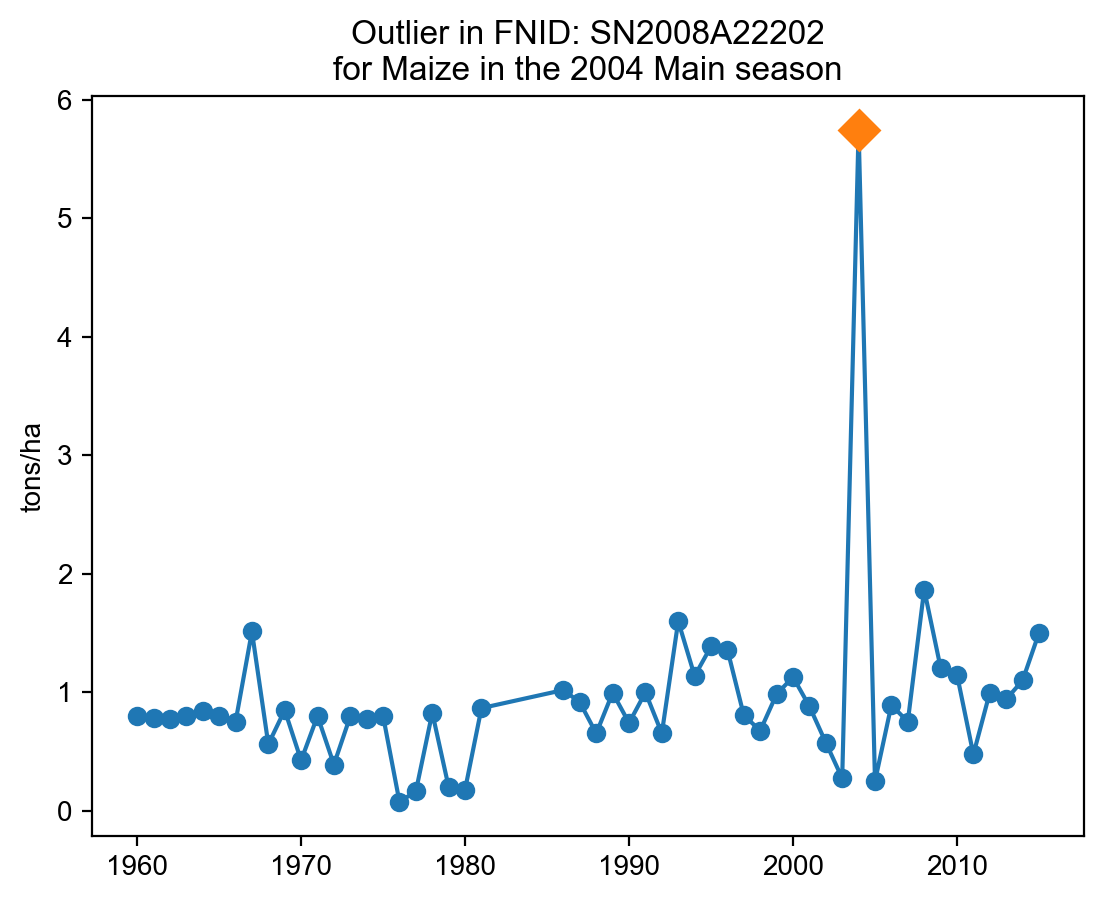

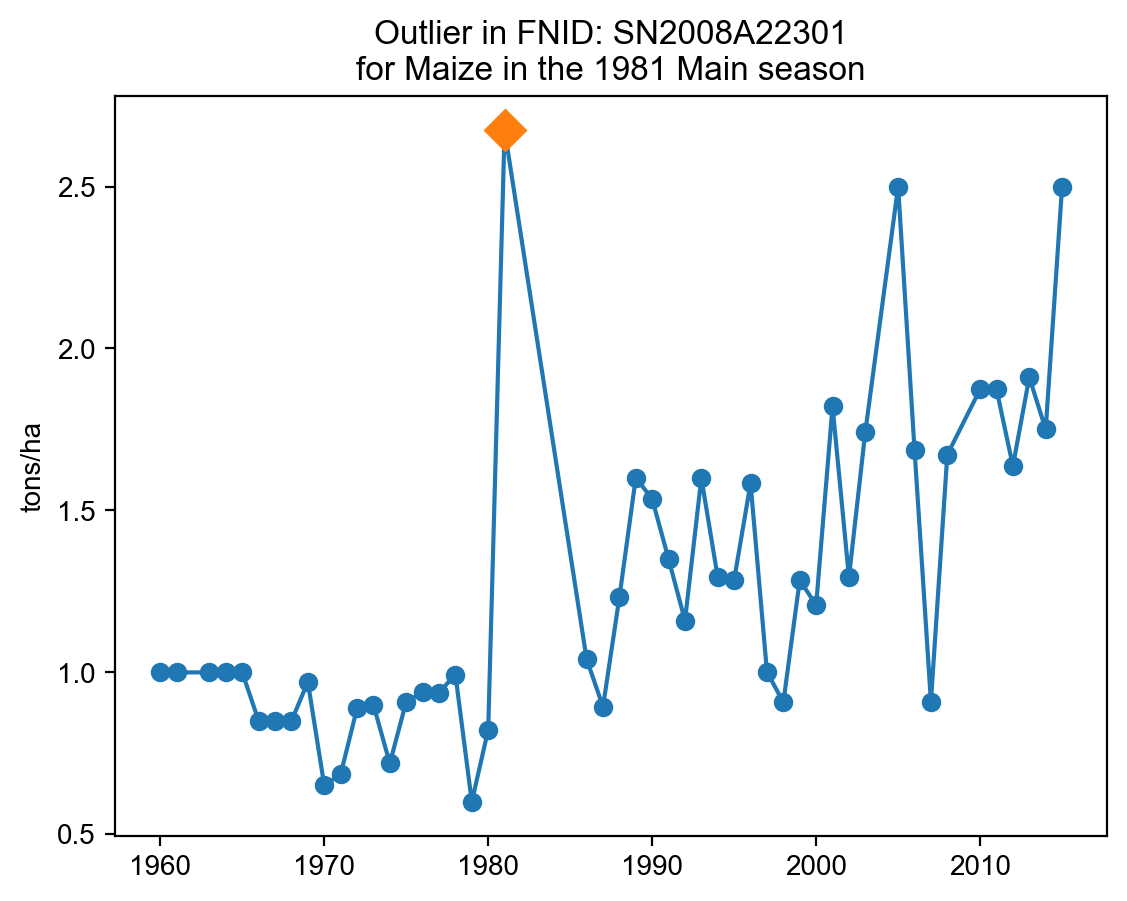

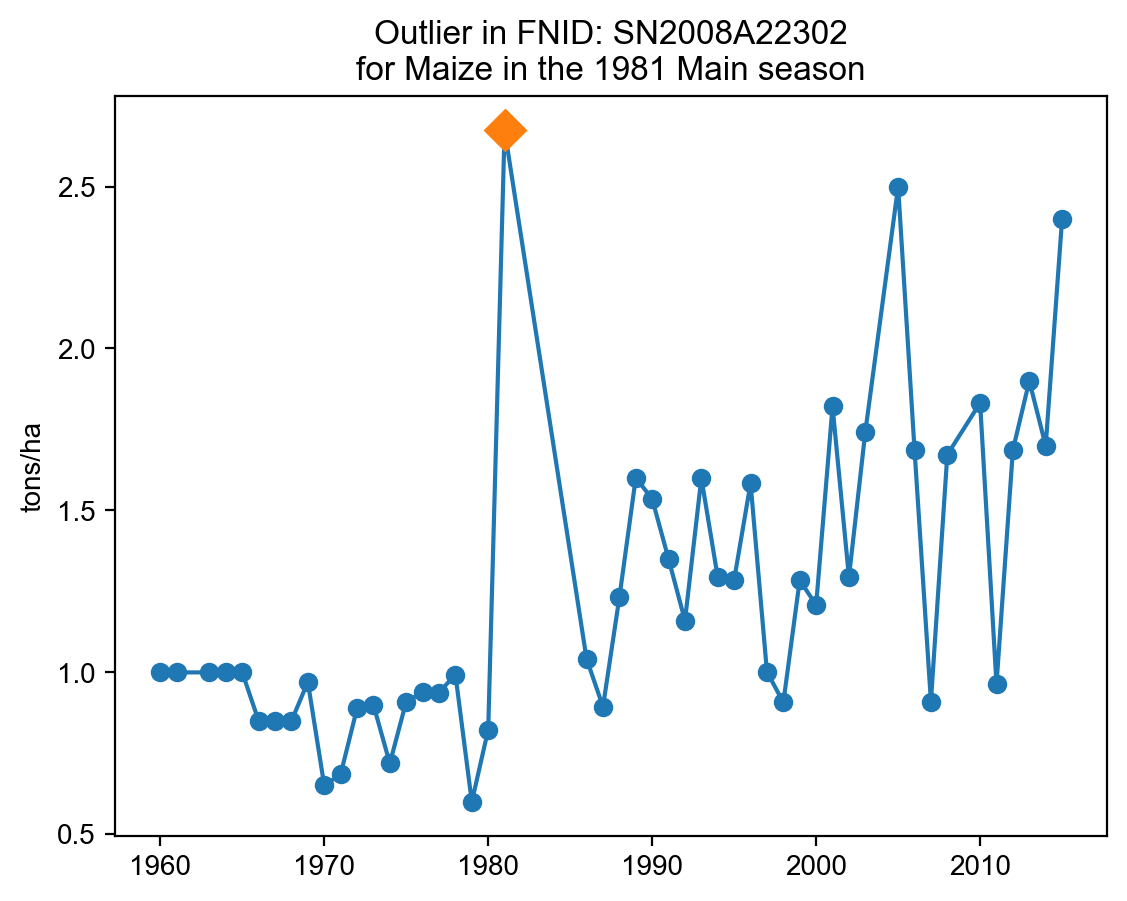

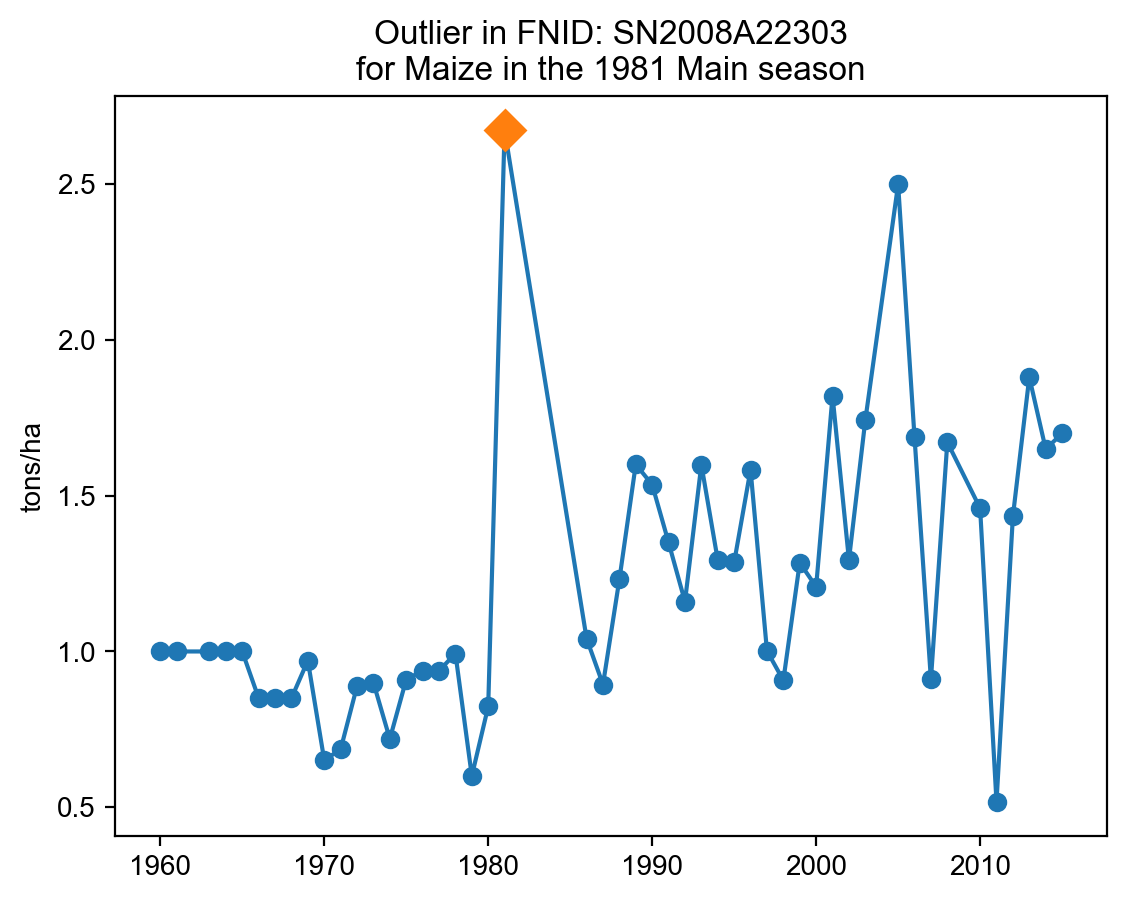

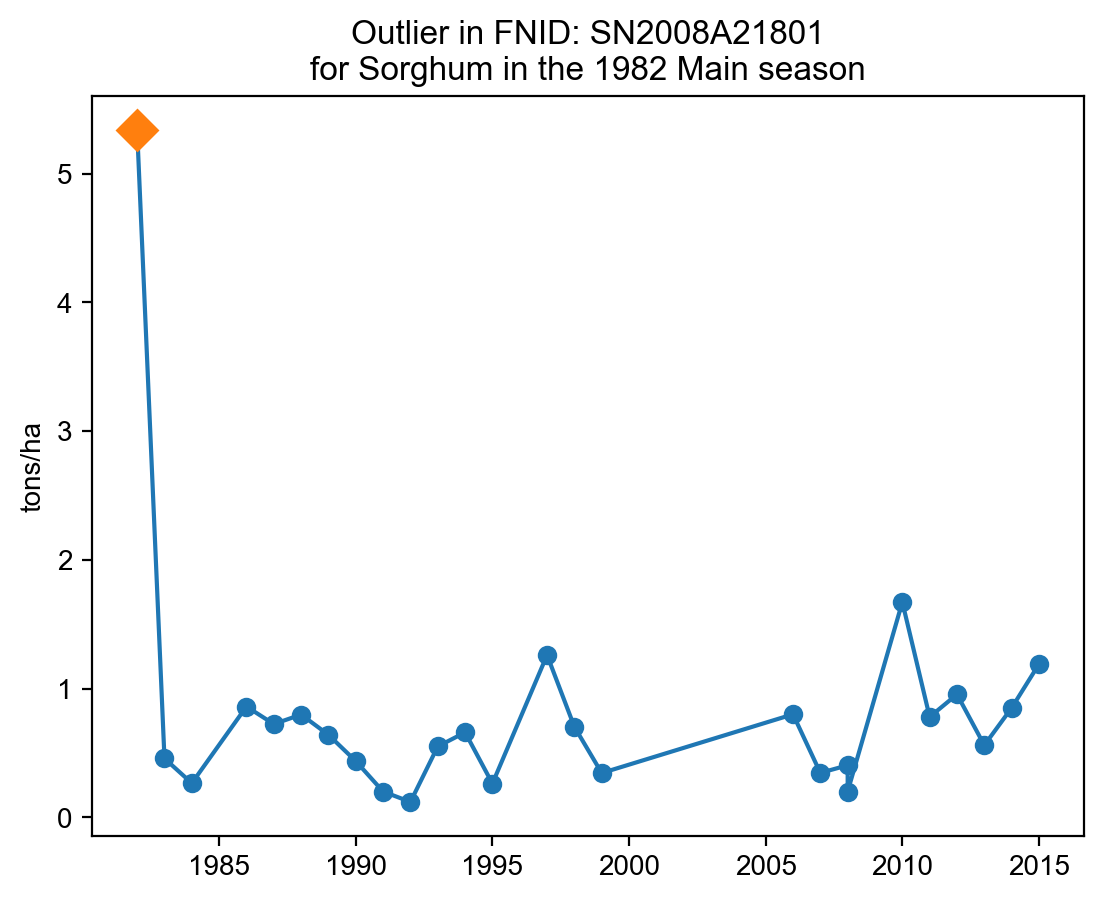

In [7]:
from matplotlib import pyplot as plt

outliers = [['SN2008A20703','Maize','Main',2008],
            ['SN2008A22201','Maize','Main',2004],
            ['SN2008A22202','Maize','Main',2004],
            ['SN2008A22301','Maize','Main',1981],
            ['SN2008A22302','Maize','Main',1981],
            ['SN2008A22303','Maize','Main',1981],
            ['SN2008A21801','Sorghum','Main',1982],
           ]
stack=stack.sort_values(by='harvest_year')

#first plot, then remove the values (yield, production and harvested area)
for iou in outliers:
    plt.figure()
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')].value.values,'-o')
    plt.plot(stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].harvest_year.values,
            stack[(stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.indicator=='yield')&(stack.harvest_year==iou[3])].value.values,'D',markersize=10)
    plt.title('Outlier in FNID: '+iou[0]+'\nfor '+iou[1]+' in the '+str(iou[3])+' '+iou[2]+' season')
    plt.ylabel('tons/ha')
    stack.loc[((stack.fnid==iou[0])&(stack['product']==iou[1])&(stack.season_name==iou[2])&(stack.harvest_year==iou[3])),'QC_flag']=1
   

In [8]:
# Save data
fn_out = '../data/crop/adm_crop_production_SN.csv'
stack.to_csv(fn_out); print(f'{fn_out} is saved.')
save_npz('../data/crop/adm_crop_production_SN_ratio.npz', link_ratio)

../data/crop/adm_crop_production_SN.csv is saved.
../data/crop/adm_crop_production_SN_ratio.npz is saved.


# Visualization of production data

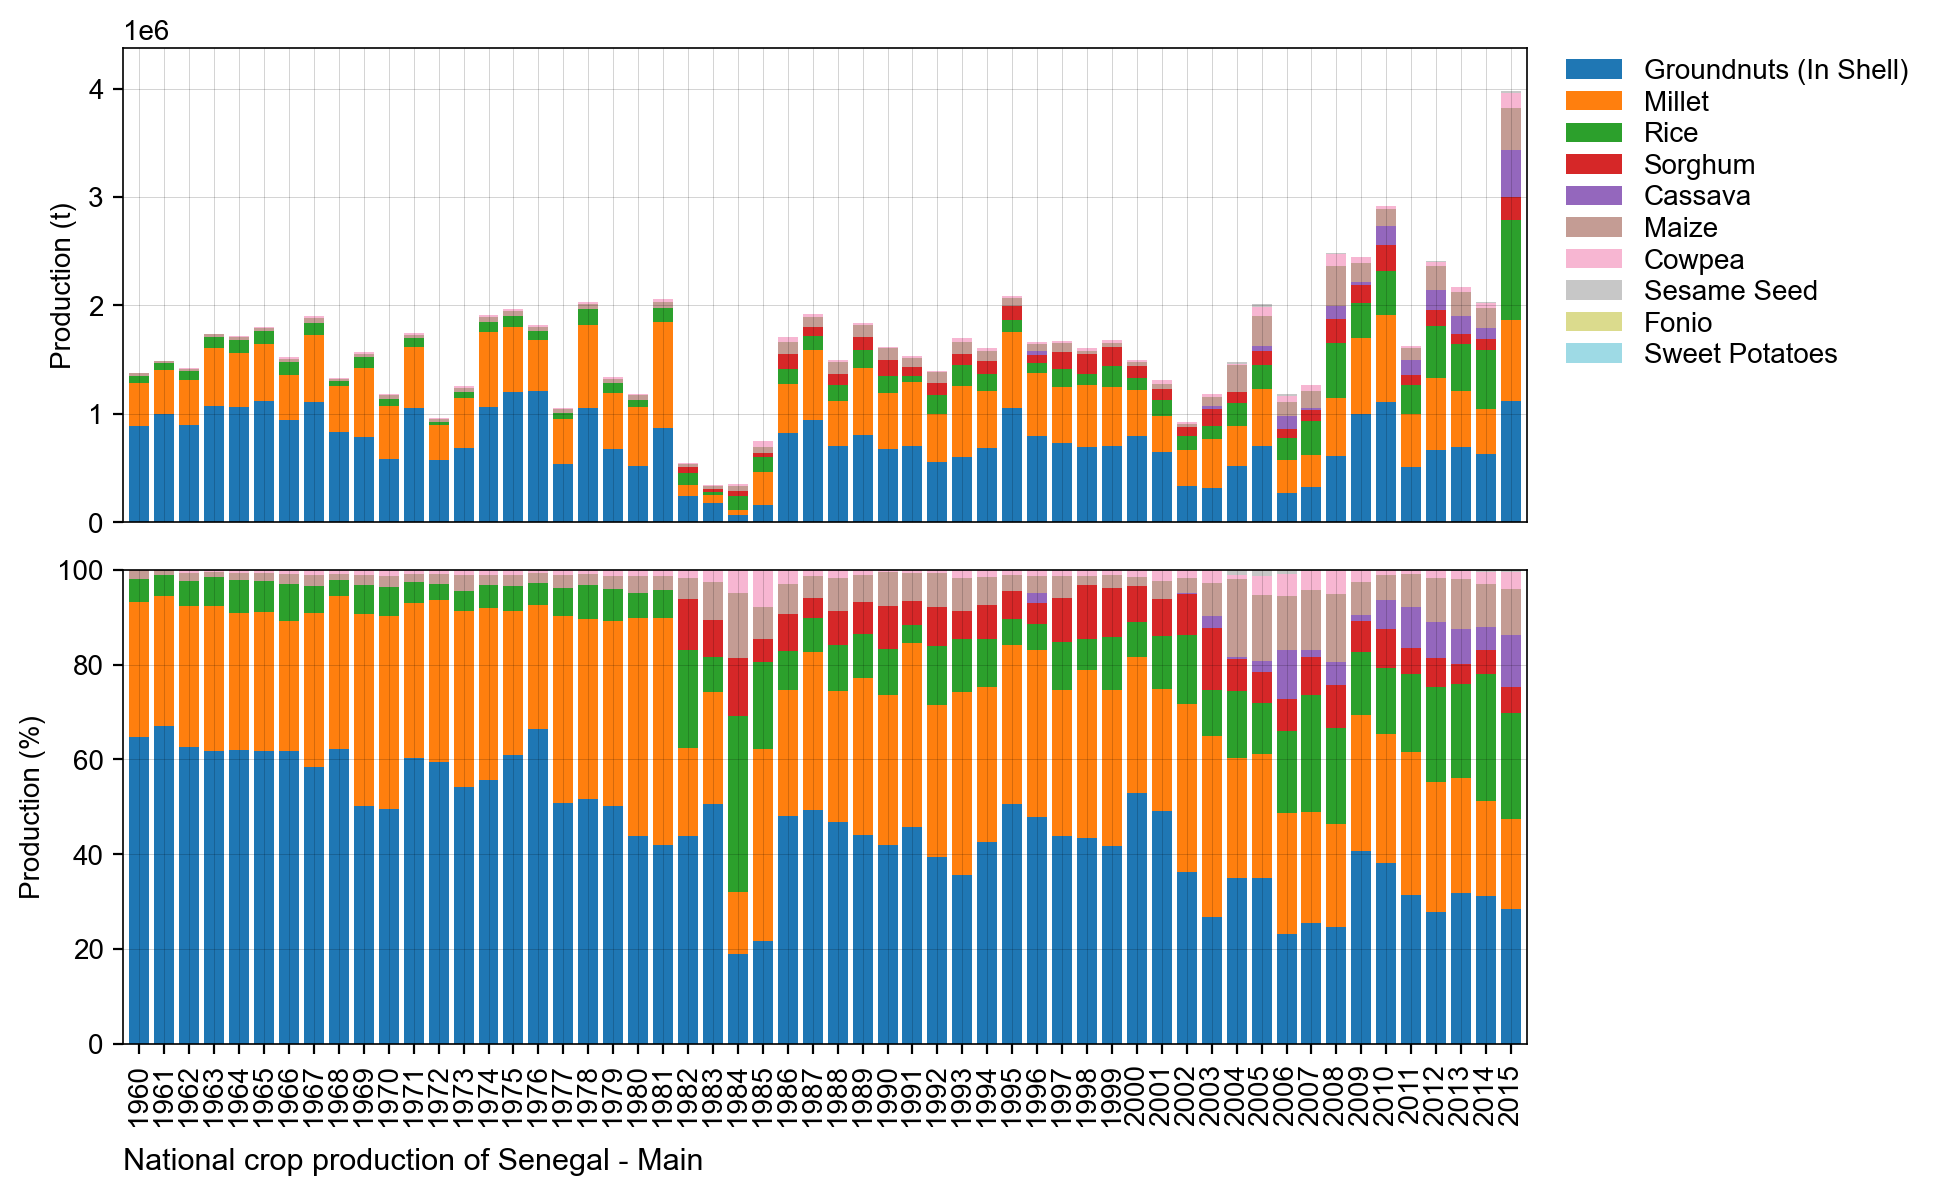

../figures/SN_bar_natgrainprod_Main.png is saved.


In [9]:
# Bar chart of national crop production
country_iso, country_name = 'SN', 'Senegal'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
for season_name in ['Main']:
    footnote = 'National crop production of %s - %s' % (country_name, season_name)
    fn_save = '../figures/%s_bar_natgrainprod_%s.png' % (country_iso, season_name)
    sub = df[df['season_name'] == season_name]
    PlotBarProduction(sub, year, footnote, fn_save)

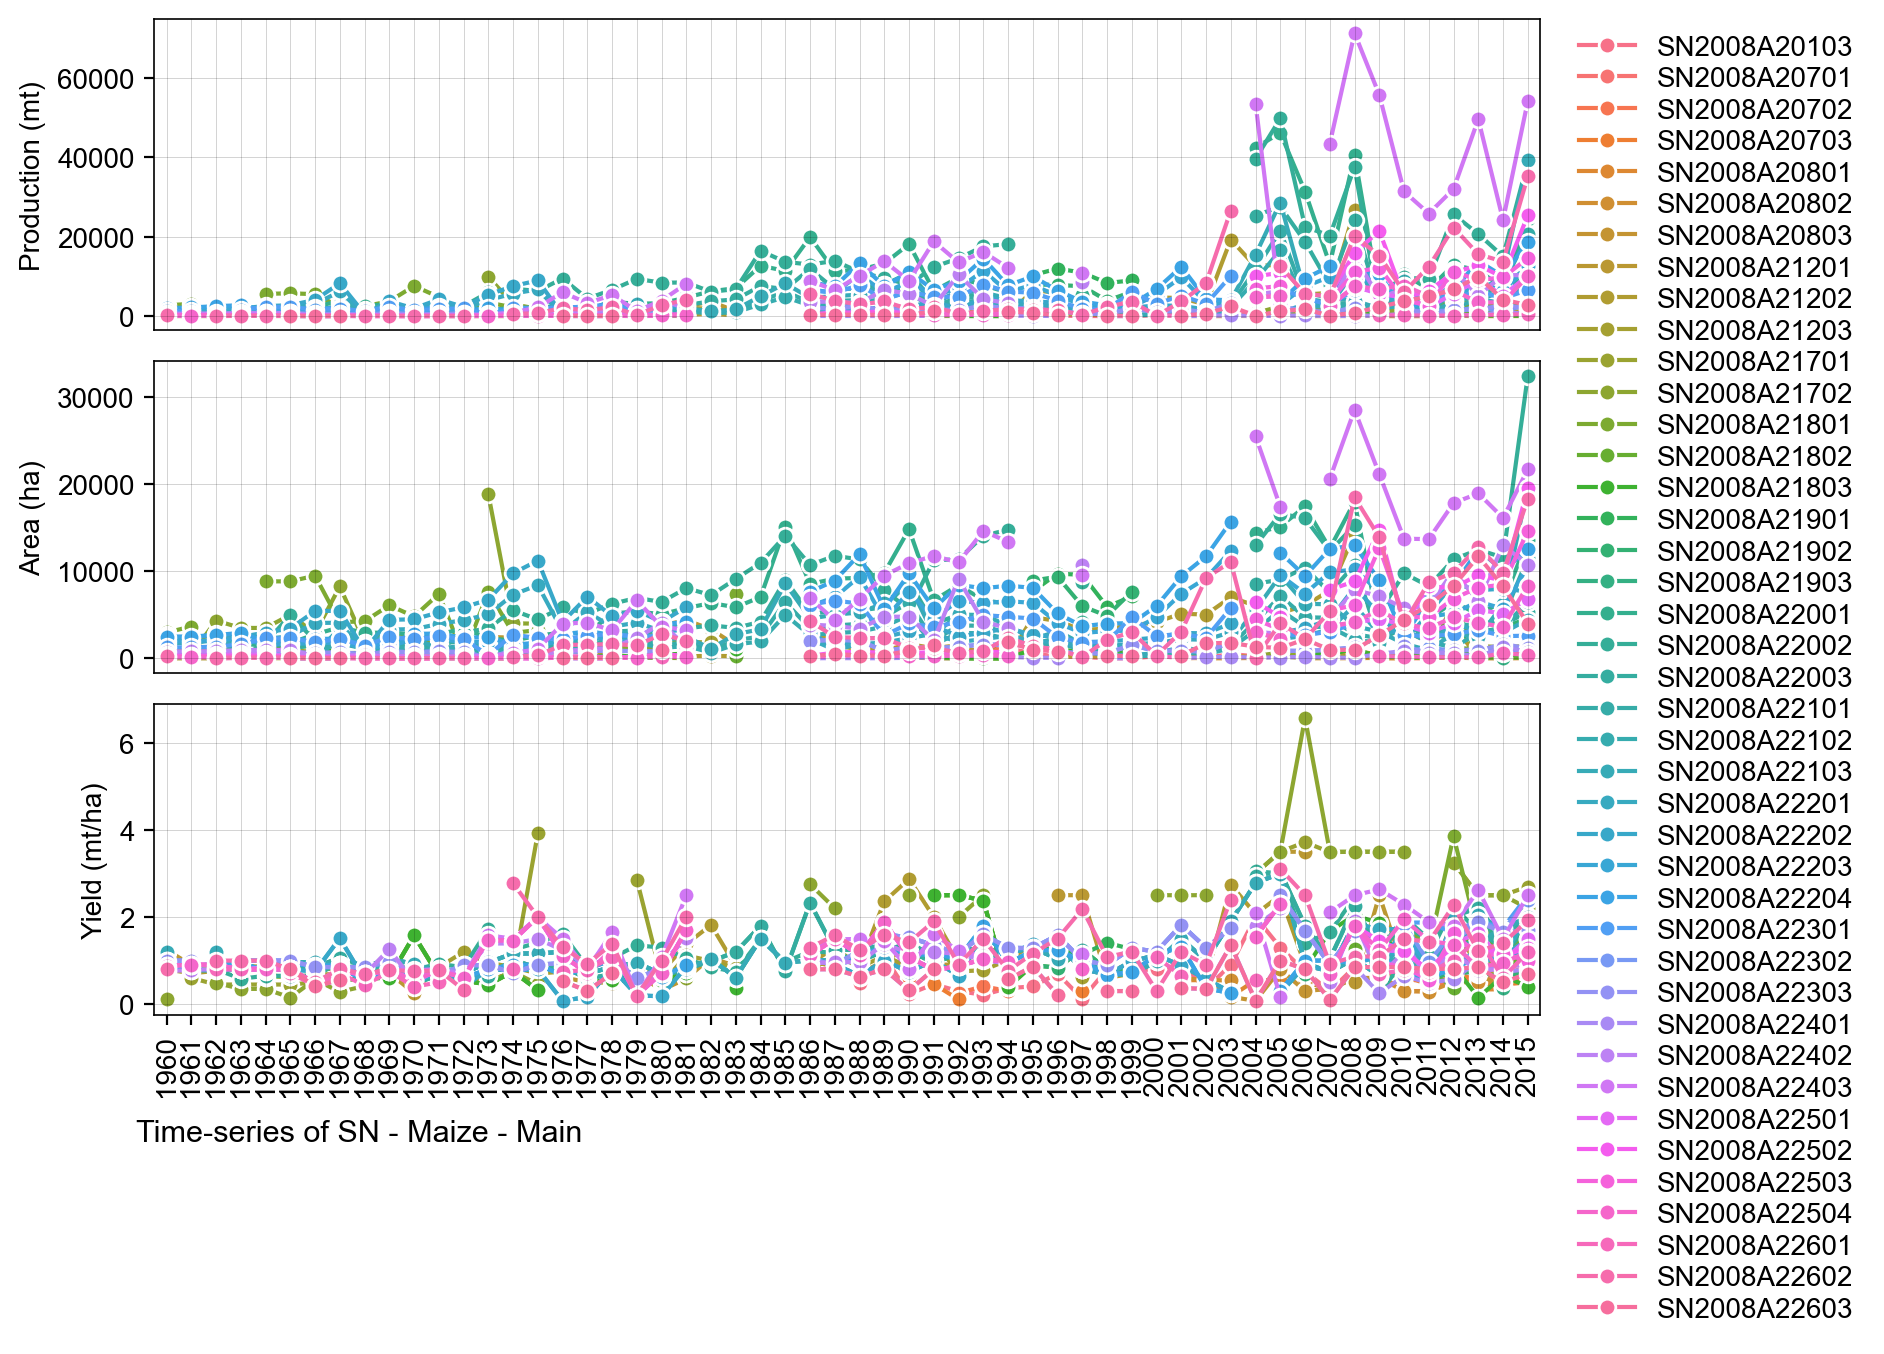

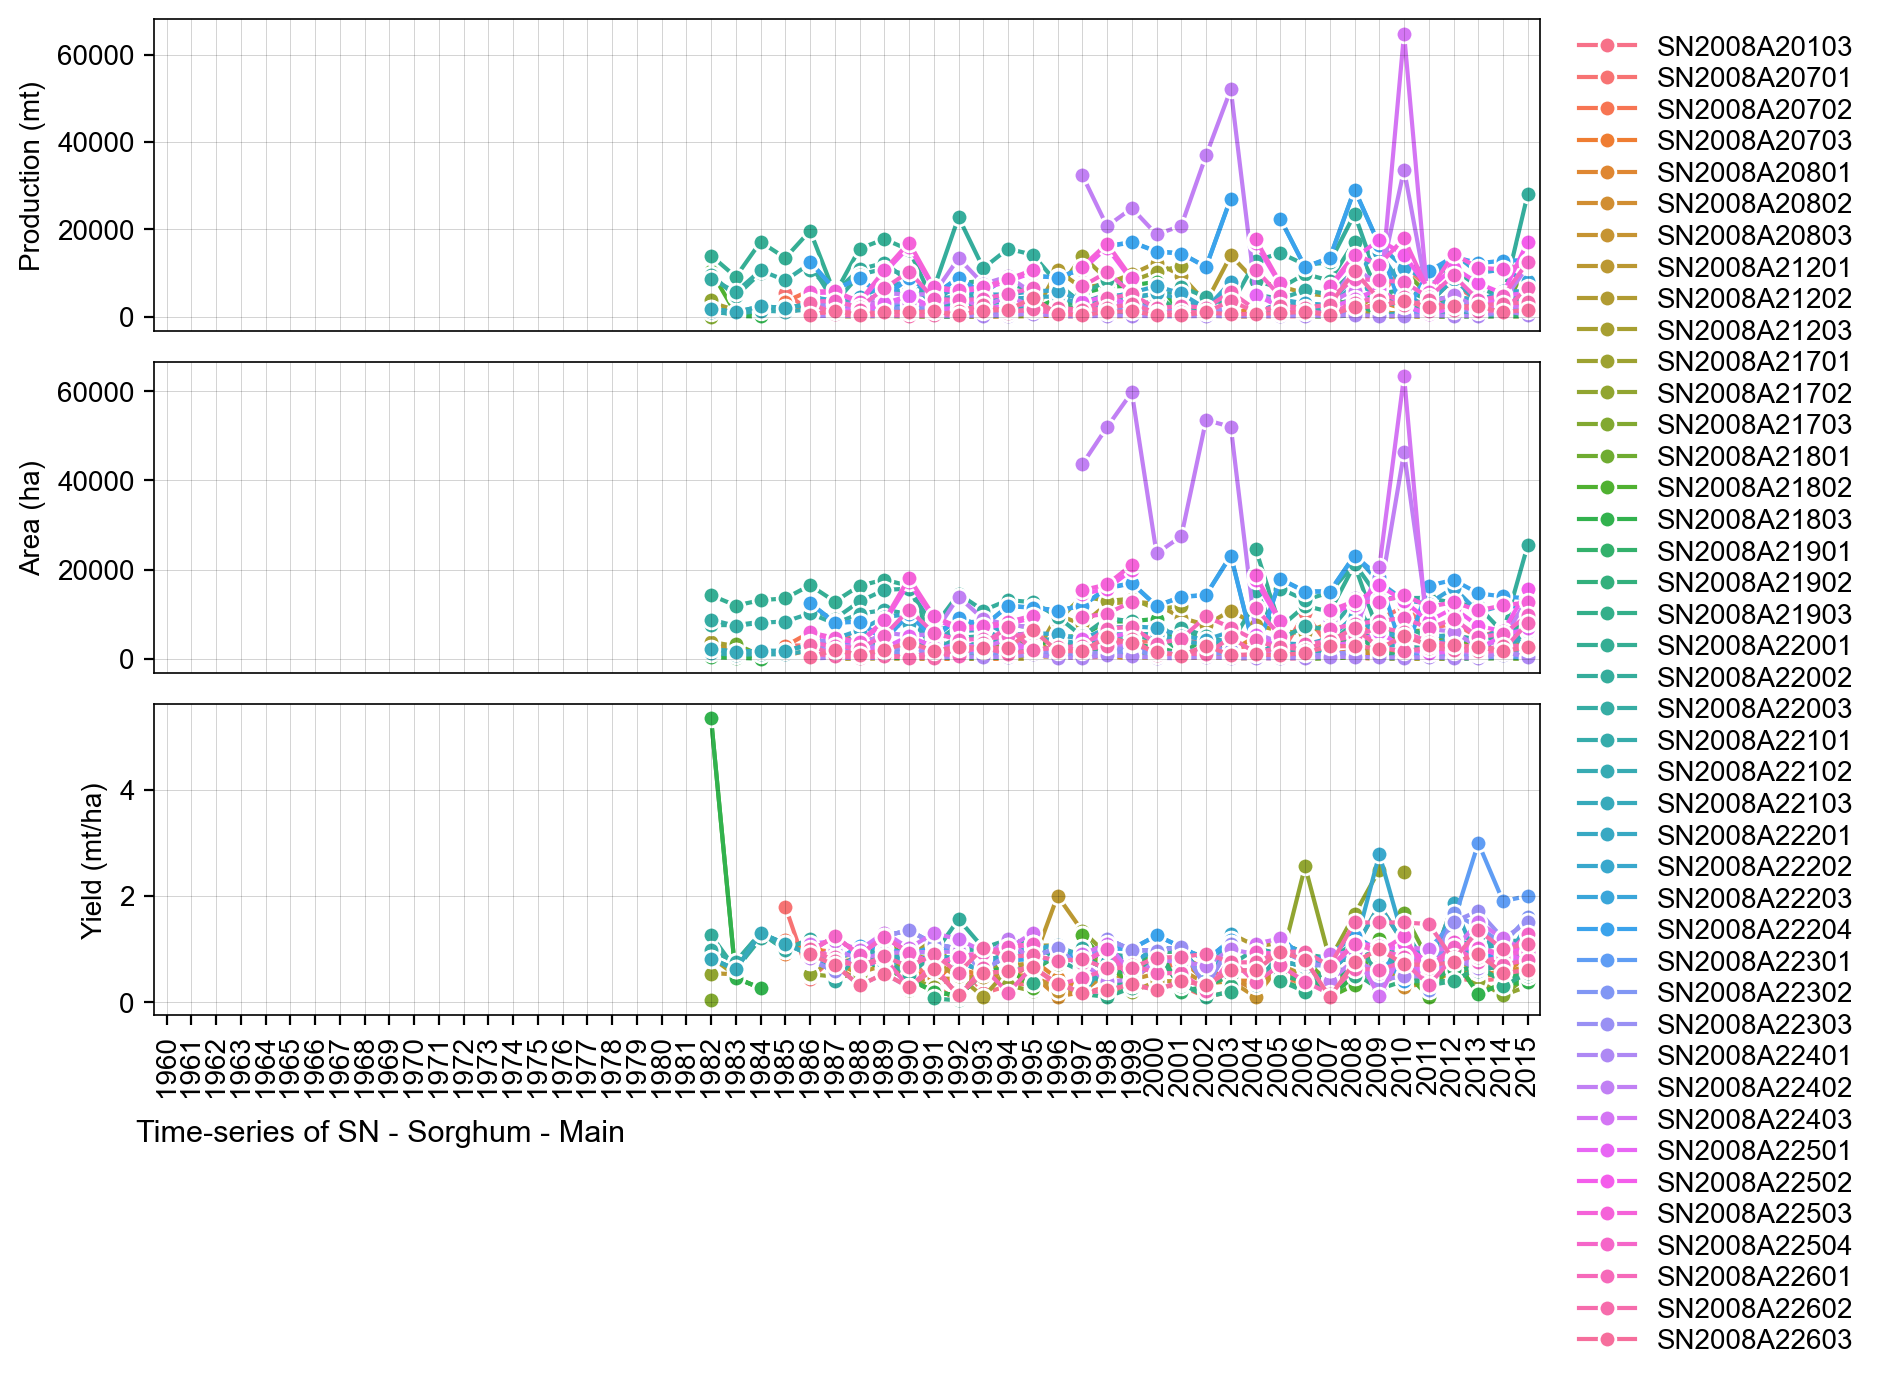

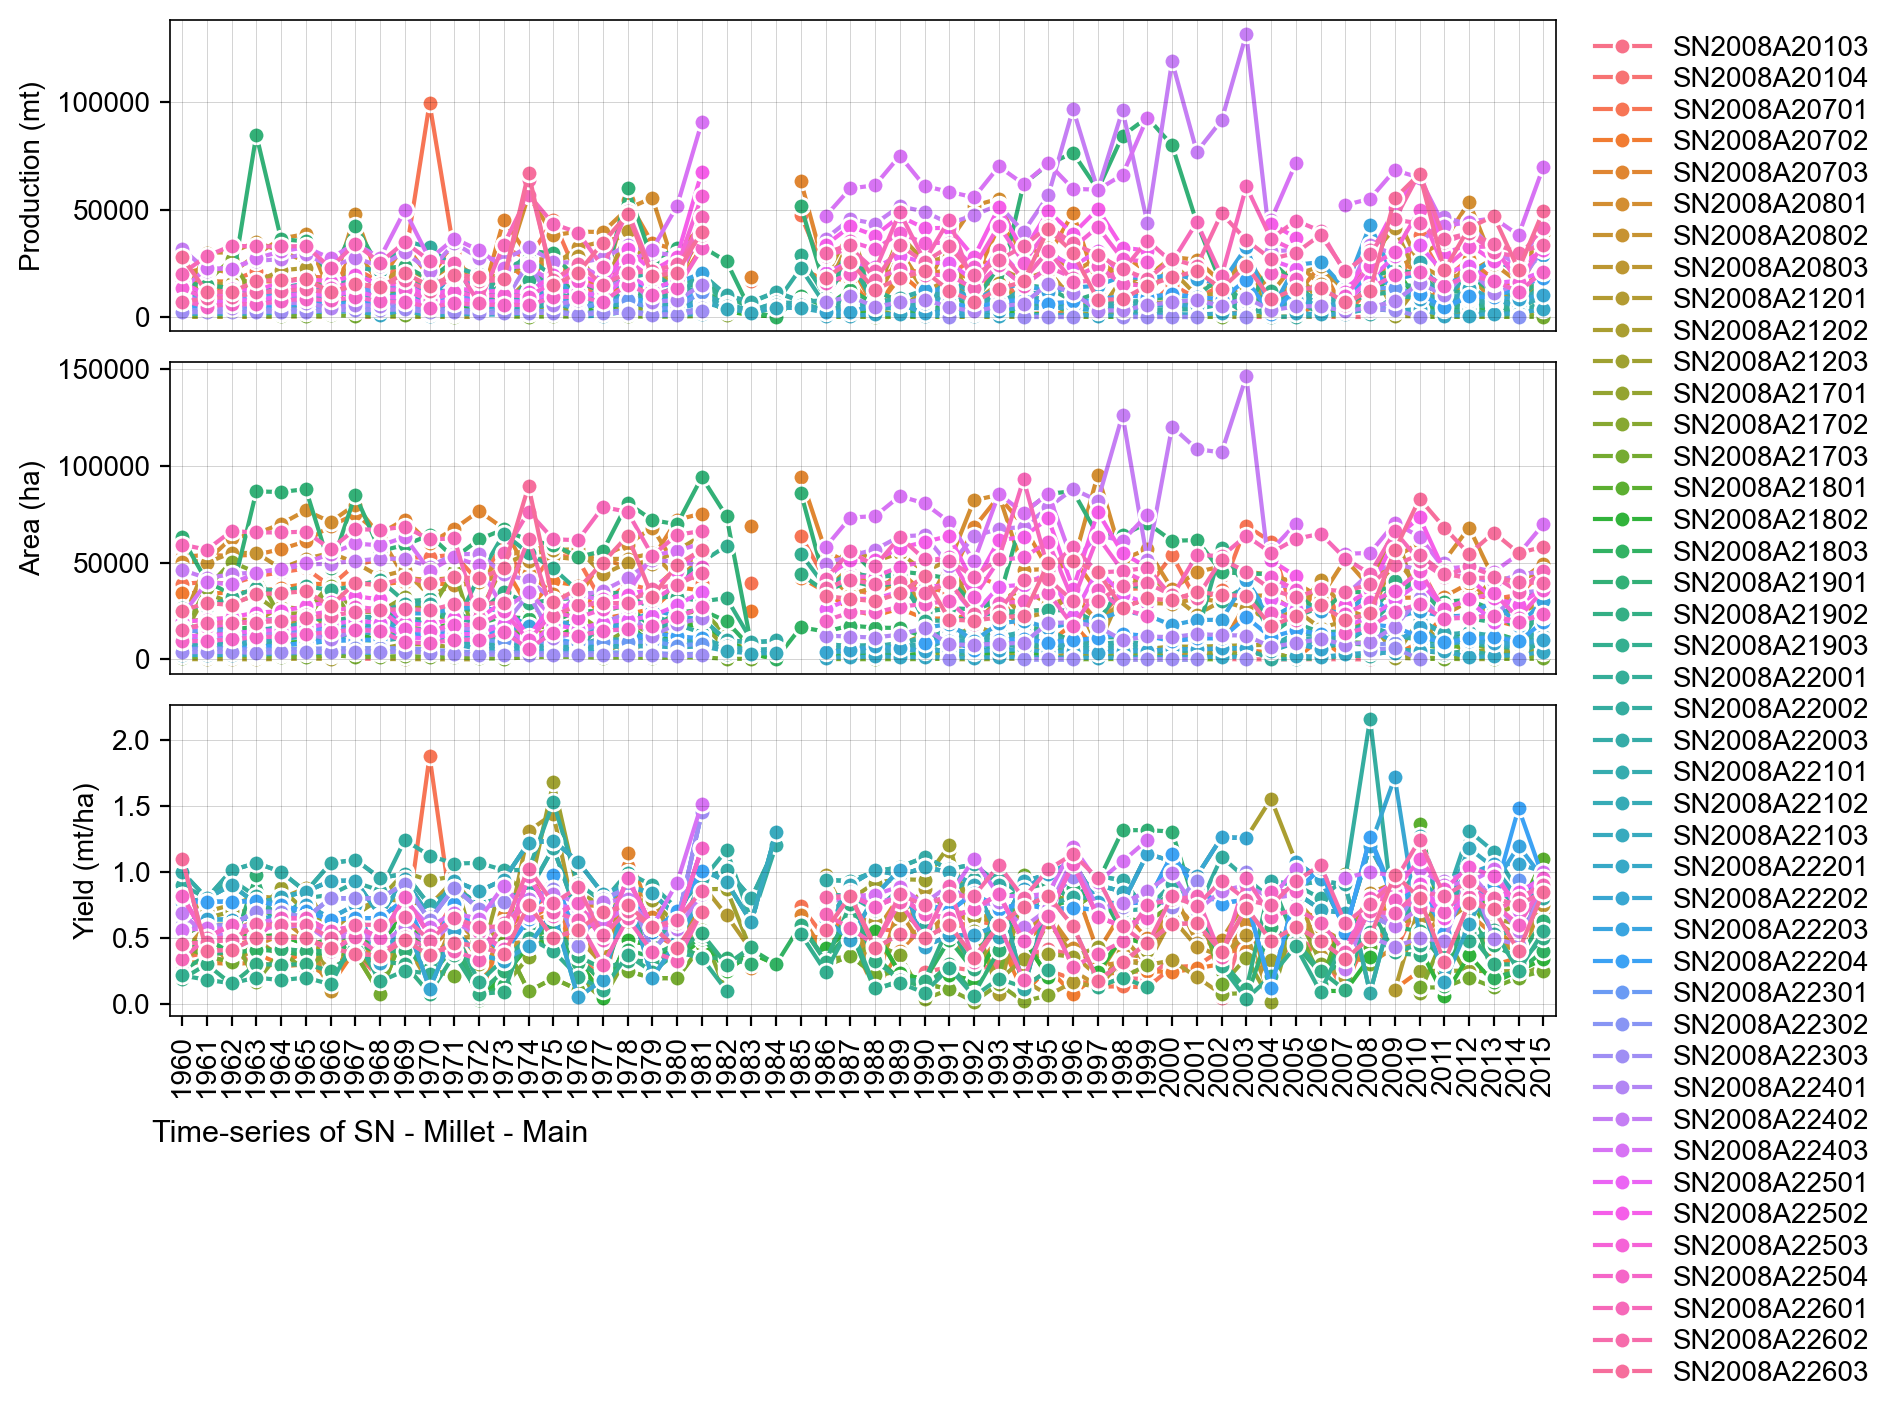

In [10]:
# Lineplot of Production-Area-Yield time-series
country_iso, country_name = 'SN', 'Senegal'
df = pd.read_csv('../data/crop/adm_crop_production_%s.csv' % country_iso, index_col=0)
df = df[df['QC_flag'] == 0] # remove outliers
df['year'] = df['harvest_year']
year = [df['year'].min(), df['year'].max()]
product_season = [
    ['Maize','Main'],
    ['Sorghum','Main'],
    ['Millet','Main'],
]
for product_name, season_name in product_season:
    footnote = 'Time-series of %s - %s - %s' % (country_iso, product_name, season_name)
    fn_save = '../figures/%s_line_pay_%s_%s.png' % (country_iso, product_name, season_name)
    sub = df[(df['product'] == product_name) & (df['season_name'] == season_name)]
    PlotLinePAY(sub, year, footnote)

<!-- ![image](https://github.com/chc-ucsb/GlobalCropData/blob/main/figures/ML_line_pay_Maize_Main.png?raw=true)
![image](https://github.com/chc-ucsb/GlobalCropData/blob/main/figures/ML_line_pay_Millet_Main.png?raw=true)
![image](https://github.com/chc-ucsb/GlobalCropData/blob/main/figures/ML_line_pay_Rice_Main.png?raw=true)
![image](https://github.com/chc-ucsb/GlobalCropData/blob/main/figures/ML_line_pay_Sorghum_Main.png?raw=true) -->